<a href="https://colab.research.google.com/github/radwahashiesh/DeepLearningBreastCancer/blob/main/VGG19_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [531]:
import numpy as np 
import pandas as pd
import os
from tensorflow import keras
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras import backend as K
# Common imports
import numpy as np
import os
import timeit
from sklearn.neural_network import MLPClassifier
 

In [532]:
import warnings
warnings.filterwarnings("ignore")

In [533]:
path = "/content/drive/MyDrive/Dataset_BUSI_with_GT (2)"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'malignant': 421, 'normal': 266}

In [534]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [535]:
df = pd.DataFrame(os.listdir(dir_list[0]))
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(str)
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

210


In [536]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,1) 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,0) 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,2)

In [537]:
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


In [538]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)
X /= 255.0
Xm /= 255.0

print(X.shape)
print(Xm.shape)
print(y.shape)


(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)


In [539]:
masks=[]
for i  in (Xm):
   img1 =  np.expand_dims(i, axis=-1)
   masks.append(img1)

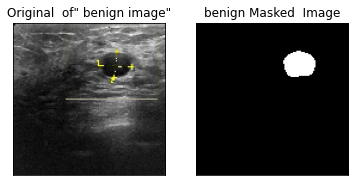

In [540]:
plt.subplot(121),plt.imshow(X[5],cmap = 'gray')

plt.title('Original  of" benign image"'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Xm[5],cmap = 'gray')
plt.title('benign Masked  Image'), plt.xticks([]), plt.yticks([])

plt.show()

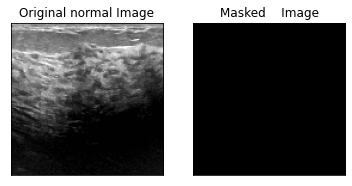

In [541]:
plt.subplot(121),plt.imshow(X[500],cmap = 'gray')
plt.title('Original normal Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(Xm[500],cmap = 'gray')
plt.title('Masked    Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [542]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(Xm,y, test_size=.2, stratify=y, random_state=42)

initializing CNN & add a convolutional layer 

In [543]:
start = timeit.default_timer()

In [544]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None
)

for l in base_model.layers:
    l.trainable = False

In [545]:
def VGG19():

    model = Sequential()
    model.add(base_model)
    
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])
    
    return model

In [546]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = VGG19()
model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', patience=10,restore_best_weights=True, verbose=1)
history = model.fit(X_train,y_train,batch_size = 32,epochs=100,validation_data=(X_test, y_test),callbacks=[es])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_23 (Flatten)        (None, 8192)              0         
                                                                 
 batch_normalization_14 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 dense_76 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_43 (Dropout)        (None, 128)               0         
                                                                 
 dense_77 (Dense)            (None, 32)                4128      
                                                     

In [547]:
end = timeit.default_timer()

Plotting loss graph

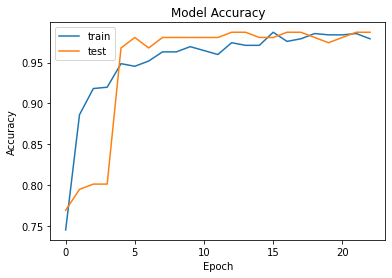

In [548]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

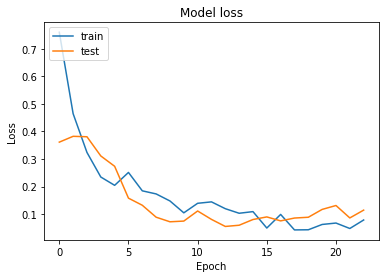

In [549]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [550]:


# Generate generalization metrics

from sklearn.metrics import accuracy_score,classification_report
y_predictt = model.predict(X_test)
y_predictt = y_predictt.argmax(axis=-1)
score=accuracy_score(y_test, y_predictt)*100
print('Accuracy of testing: \n{0}'.format(score))
pred = model.predict_generator(X_test)
y_predict = pred.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix of testing: \n{0}'.format(conf_mx))
print(classification_report(y_test, y_predict))
print('time to VGG19 model in seconds is : \n{0}'.format(end-start))



Accuracy of testing: 
98.71794871794873
Confusion matrix of testing: 
[[27  0  0]
 [ 0 87  0]
 [ 0  2 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.98      1.00      0.99        87
           2       1.00      0.95      0.98        42

    accuracy                           0.99       156
   macro avg       0.99      0.98      0.99       156
weighted avg       0.99      0.99      0.99       156

time to VGG19 model in seconds is : 
37.04022561700003


In [551]:
#model.save("VGG19_MASKED_Model.h5")